# Chapter 08 - Dimensionality Reduction

## The curse of dimensionality

high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away
from each other because they are trapped in a high-dimensional space. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, the more dimensions the training set has, the greater the risk of overfitting it.

## Main Approaches for dimensionality Reduction

### Projection

In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated (as discussed earlier for MNIST). As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional
space.

### Manifold learning

Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More
generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In the case of the Swiss roll, d = 2 and n = 3: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called Manifold Learning. It relies on the manifold assumption, also called the manifold hypothesis, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.

## PCA (Linear projections)

### Vanilla PCA

Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it, just like in Figure 8-2 that lies below.

To criteria to choose the right hyperplane is to select the projected hyperplane that preserves the maximum variance, as it will most likely lose less information than the other projections. 
Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis.

PCA identifies the axis that accounts for the largest amount of variance in the training set. Then, it draws another axis, each perpendicular to all others in order to count for the remaining dimensions. The i-th axis is called the i-th principal component.

To find the principal components, PCA uses the SVD matrix factorization technique that decomposes a matrix in $U \Sigma V^T$, where $V$ contains the unit vectors that define all principal components that we are looking for. Also, note that the data must be centered around 0 mean to perform PCA.

In [21]:
import numpy as np
import matplotlib.pyplot as plt 

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [22]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [24]:
X3D_inv = pca.inverse_transform(X2D)

In [25]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

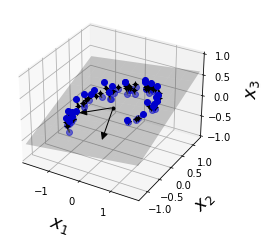

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

# save_fig("dataset_3d_plot")
plt.show()

#### Projecting down to d dimensions

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$
of dimensionality d, compute the matrix multiplication of the training set
matrix X by the matrix $W_d$, defined as the matrix containing the first d columns
of V, as shown in Equation 8-2 below.

$$X_{d-proj} = X W_d$$

In [27]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

Note that this is the same as calling  

```
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
``` 

As we did before. That's because scikit-learn also used SVD decomposition to compute the PCA.

#### Explained Variance Ratio

Another useful piece of information is the explained variance ratio of each principal component, available via the *explained_variance_ratio_* variable. The ratio indicates the proportion of the dataset’s variance that lies along each principal component. For example, let’s look at the explained variance:

In [28]:
explained_var = pca.explained_variance_ratio_

In [29]:
sum(explained_var)

0.988804464429311

This indicates the reducing the dataset down to 2 dimensions kept 98.888% percent of information. Therefore, the third axis does not hold much variance.

#### Choosing the right number of dimensions

There are some ways to choose the right number of dimensions. We could set a threshold over the explained variance ratio vector, and only consider the number of dimensions equivalent to 95% percent of all variation in the data:

In [30]:
# pca = PCA()
# pca.fit(X_train)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1

Or we could simply pass a float to scikit-learn *PCA()*, and it will understand that we want to projecting down to the number of dimensions needed to achieve such explained variance:

In [31]:
# pca = PCA(n_components=0.95)
# X_reduced = pca.fit_transform(X_train)

Moreover, we also plot the number of dimensions vs the explained variance accumulated sum, and look for an elbow in the graph indicating that from that point, the explained variance remains approximately constant as the number of dimensions increases.

### PCA for compression

It is possible to use PCA for data compression. By doing so, we are capable to reduce the number of features in a dataset and consequently speed up training and save storage. On the other hand, we can apply PCA to compress a dataset and also decompress it. Of course, since the compression throws away some information about the data, the decompression won't give us exactly the original data. However, the results might still be pretty good.

The following code compresses the MNIST dataset down to 154 dimensions, then uses the inverse_transform() method to decompress it back to 784 dimensions:

In [32]:
# pca = PCA(n_components = 154)
# X_reduced = pca.fit_transform(X_train)
# X_recovered = pca.inverse_transform(X_reduced)

The equation of the inverse transformation is shown in Equation 8-3:

$$X_{recovered} = X_{d-proj}W_d^T$$

The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the reconstruction error.

### Randomized PCA

Scikit-learn let us choose which derivation from the PCA technique we want to choose provided at the argument *svd_solver*. Passing "randomized" as the argument, we allow the API to use an stochastic algorithm called Randomized PCA that quickly finds an approximation of the first d principal components. Its computational complexity is $O(m × d^2) + O(d^2)$, instead of $O(m × n^2) + O(n^2)$ for the full SVD approach, so
it is dramatically faster than full SVD when d is much smaller than n:

In [33]:
# rnd_pca = PCA(n_components=154, svd_solver="randomized")
# X_reduced = rnd_pca.fit_transform(X_train)

By default, svd_solver is actually set to "auto": Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to "full".

### Incremental PCA

One huge disadvantage of PCA is that we need to feed the whole data to the PCA function. Fortunately, *Incremental PCA (IPCA)* algorithms have been developed. They allow us to feed part of the data into the PCA algorithm such that we can use it iteratively to train PCA on the fly:

The following code splits the MNIST dataset into 100 mini-batches (using NumPy’s array_split() function) and feeds them to Scikit-Learn’s *IncrementalPCA* class to reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like before). Note that you must call the *partial_fit()* method with each mini-batch, rather than the *fit()* method with the whole training set:

In [34]:
# from sklearn.decomposition import IncrementalPCA

# n_batches = 100
# inc_pca = IncrementalPCA(n_components=154)

# for X_batch in np.array_split(X_train, n_batches):
#   inc_pca.partial_fit(X_batch)
#   X_reduced = inc_pca.transform(X_train)

## Kernel PCA (Nonlinear projections)

In Chapter 5 we discussed the kernel trick, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space.

It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called Kernel PCA (kPCA). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted
manifold.

The idea here is quite the same, this technique is call *Kernel PCA (kPCA)*, and we can use Scikit-Learn's *KernelPCA* class to perform kPCA 

In [35]:
# from sklearn.decomposition import KernelPCA

# rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
# X_reduced = rbf_pca.fit_transform(X)

It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

### Selecting a Kernel and Tuning Hyperparameters

Selecting a kernel and the best parameters is no trivial task. However, keep in mind that often, dimensionality reduction is just a preparation step to another task (classification, regression). In such cases, we can play with the parameters by doing a Grid Search CV over the parameters of kPCA in order to maximize a chosen metrics, such as accuracy.

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
  ("kpca", KernelPCA(n_components=2)),
  ("log_reg", LogisticRegression())
])

param_grid = [{
  "kpca__gamma": np.linspace(0.03, 0.05, 10),
  "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

NameError: name 'KernelPCA' is not defined

The best kernel and hyperparameters are then available through the *best_params_* variable: `grid_search.best_params_`.

Another Another approach, this time entirely unsupervised, is to select the kernel and
hyperparameters that yield the lowest reconstruction error. Since we are talking about kPCA, the reconstruction is not as easy as for the linear PCA (standard PCA), beyond the dimensionality reduction, we also have a feature map step because of the kernel transformation.

Notice that if we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in feature space, not in the original space. Since the feature space is infinite-dimensional, we cannot compute the reconstructed point, and therefore we cannot compute the true reconstruction error. Fortunately, it is possible to find a point in the original space that would map close to the reconstructed point. This point is called the reconstruction pre-image. Once you have this pre-image, you can measure its squared distance to the original instance. You can then select the kernel and hyperparameters that minimize this reconstruction pre-image error.

You may be wondering how to perform this reconstruction. One solution is to train a supervised regression model, with the projected instances as the training set and the original instances as the targets. Scikit-Learn will do this automatically if you set *fit_inverse_transform=True*, as shown in the following code:

In [ ]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)

X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

Now you can use grid search with cross-validation to find the kernel and hyperparameters that minimize this error.

## LLE

Until this point, we have only learned about dimensionality reduction techniques based on projection. Locally Linear Embedding is a powerful nonlinear dimensionality reduction technique. It is a Manifold Learning technique that does not rely on projections, like the previous algorithms do. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details
shortly). This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

Here’s how LLE works: for each training instance $x^{(i)}$, the algorithm identifies its k closest neighbors (in the preceding code k = 10), then tries to reconstruct $x^{(i)}$ as a linear function of these neighbors. More specifically, it finds the weights $w_{i, j}$ s.t. the squared distance between $x^{(i)}$ and $\sum_{j=1}^m w_{i, j}x^{(j)}$ is as small as possible, assuming $w_{i, j} = 0$ if $x^{(j)}$ is not one of the k closest neighbors of $x^{(i)}$.

$$
\hat{W} = argmin_W \sum_{i=1}^m (x^{(i)} - \sum_{j=1}^m w_{i,j}x^{(j)})^2
$$


After this step, the weight matrix $\hat{W}$ (containing the weights $\hat{w}_{i,j}$) encodes the
local linear relationships between the training instances. The second step is to map the training instances into a d-dimensional space (where d < n) while preserving these local relationships as much as possible. If $z^{(i)}$ is the image of $x^{(i)}$ in this d-dimensional space, then we want the squared distance between $z^{(i)}$ and $\sum_{j=1}^m \hat{w}_{i, j}z^{(j)}$ to be as small as possible. This idea leads to the unconstrained
optimization problem described in Equation 8-5. It looks very similar to the first step, but instead of keeping the instances fixed and finding the optimal weights, we are doing the reverse: keeping the weights fixed and finding the optimal position of the instances’ images in the low-dimensional space.

$$
\hat{Z} = argmin_Z \sum_{i=1}^m (z^{(i)} - \sum_{j=1}^m \hat{w}_{i,j}z^{(j)})^2
$$

Scikit-Learn’s LLE implementation has the following computational complexity:
$O(m log(m)n log(k))$ for finding the k nearest neighbors, $O(mnk^2)$ for optimizing
the weights, and $O(dm^2)$ for constructing the low-dimensional representations.
Unfortunately, the $m^2$ in the last term makes this algorithm scale poorly to very
large datasets.

In [ ]:
# from sklearn.manifold import LocallyLinearEmbedding

# lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
# X_reduced = lle.fit_transform(X)

## Other dimensionality reduction techniques

### Random Projections

As its name suggests, projects the data to a lower-dimensional space using a random linear projection. This may sound crazy, but it turns out that such a random projection is actually very likely to preserve distances well, as was demonstrated mathematically by William B. Johnson and Joram Lindenstrauss in a famous lemma. The quality of the dimensionality reduction depends on the number of instances and the target dimensionality, but surprisingly not on the initial dimensionality. Check out the documentation for the *sklearn.random_projection* package for more details.

### Multidimensional Scaling (MDS)

Reduces dimensionality while trying to preserve the distances between the instances.

### Isomap

Creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances.

The geodesic distance between two nodes in a graph is the number of nodes on the shortest path between these nodes.

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).

### Linear Discriminant Analysis (LDA)

Is a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.